In [126]:
import re
import os
import pickle
import time
import numpy as np
import pandas as pd
from pathlib import Path
from Core.inputparse import Parser
from SALib.sample.morris import sample as morris_sample

In [22]:
tmap = pd.ExcelFile('Data/Techmap/DEModel_V2.xlsx')
df = pd.read_excel(tmap,"ConversionSubProcess",skiprows=[1,2]).drop(columns=['is_storage', 'efficiency', 'technical_availability', 'output_profile', 'availability_profile'])

In [27]:
cs_names = np.array([])
cs_values = np.array([])
pattern = re.compile(r'\s*;\s*|\s+')
for i in range(len(df)):
    if df.iloc[i]["conversion_process_name"] == 'DEBUG':
        break
    else:
        if type(df.iloc[i]['conversion_process_name']) != str:
            continue
        cs = df.iloc[i].dropna()
        cs_name = f'{cs["conversion_process_name"]}&{cs["commodity_in"]}&{cs["commodity_out"]}'
        remaining_columns = cs.index
        for col in remaining_columns[4:]:
            value = cs[col]
            if type(value) == str:
                year_values = pattern.split(value[1:-1])
                for j in range(0, len(year_values), 2):
                    year_value = -1 if year_values[j+1] == 'NaN' else float(year_values[j+1])
                    cs_names = np.append(cs_names, f'{cs_name}&{col}&{year_values[j]}')
                    cs_values = np.append(cs_values, year_value)
            else:
                cs_names = np.append(cs_names, f'{cs_name}&{col}')
                cs_values = np.append(cs_values, value)

In [28]:
cs_names

array(['Import_Biomass&Dummy&Biomass&spec_co2',
       'Import_Biomass&Dummy&Biomass&opex_cost_energy',
       'Import_Biomass&Dummy&Biomass&max_eout',
       'Import_Coal&Dummy&Coal&spec_co2',
       'Import_Coal&Dummy&Coal&opex_cost_energy&2016',
       'Import_Coal&Dummy&Coal&opex_cost_energy&2030',
       'Import_Coal&Dummy&Coal&opex_cost_energy&2050',
       'Import_Crude_Oil&Dummy&Crude_Oil&spec_co2',
       'Import_Crude_Oil&Dummy&Crude_Oil&opex_cost_energy&2016',
       'Import_Crude_Oil&Dummy&Crude_Oil&opex_cost_energy&2030',
       'Import_Crude_Oil&Dummy&Crude_Oil&opex_cost_energy&2050',
       'Import_Lignite&Dummy&Lignite&spec_co2',
       'Import_Lignite&Dummy&Lignite&opex_cost_energy',
       'Import_Natural_Gas&Dummy&Natural_Gas&spec_co2',
       'Import_Natural_Gas&Dummy&Natural_Gas&opex_cost_energy&2016',
       'Import_Natural_Gas&Dummy&Natural_Gas&opex_cost_energy&2030',
       'Import_Natural_Gas&Dummy&Natural_Gas&opex_cost_energy&2050',
       'Import_Uranium&Dumm

In [29]:
original_params = {}
modified_params = {}

# TODO revise these definitions
fraction_params = ['efficiency_charge', 'out_frac_min', 'out_frac_max', 'in_frac_min', 'in_frac_max']
params_5_percent = ['efficiency_charge', 'c_rate', 'technical_lifetime']
params_10_percent = ['spec_co2', 'opex_cost_power', 'max_eout', 'min_eout']
params_20_percent = ['opex_cost_energy', 'capex_cost_power']
problem_params = ['cap_res_max', 'cap_res_min', 'cap_min', 'cap_max']+params_10_percent+params_5_percent+fraction_params
for i in range(len(cs_names)):
    if any(substring in cs_names[i] for substring in params_20_percent):
        percentage_range = 0.2
    elif any(substring in cs_names[i] for substring in params_5_percent):
        percentage_range = 0.05
    else:
        percentage_range = 0.1
    is_fraction = True if any(substring in cs_names[i] for substring in fraction_params) else False
        
    original_params[cs_names[i]] = cs_values[i]
    
    if not (cs_values[i] == 0 or cs_values[i] == 1 or cs_values[i] == -1) and not(any(substring in cs_names[i] for substring in problem_params)):
        value_range = [cs_values[i]*(1-percentage_range), cs_values[i]*(1+percentage_range)]
        if is_fraction:
            np.clip(value_range,0,1)
        modified_params[cs_names[i]] = value_range

In [32]:
problem = {
    'num_vars': len(modified_params),
    'names': list(modified_params.keys()),
    'bounds': list(modified_params.values())
}
try:
    objects = []
    with (open('GSAResults/var_names.pkl', "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    out_names = objects[0]
    problem['outputs'] = out_names
except:
    pass

In [35]:
# Generate samples
trajectories = 100
optimal_trajectories = 2
start_time = time.time()
samples = morris_sample(problem, trajectories, optimal_trajectories=optimal_trajectories)
sampling_time = time.time() - start_time

In [36]:
base_cs = pd.read_excel(tmap,"ConversionSubProcess",  skiprows=[1, 2])
input_dfs = []

In [38]:
for i in range(len(samples)):
    new_params = original_params
    for idx, key in enumerate(modified_params):
        new_params[key] = samples[i][idx]
    mod_cs = base_cs.copy()
    last_yearly = ''
    yearly_input = []
    range_names = list(new_params.keys())
    for j in range(len(range_names)):
        split_name = range_names[j].split('&')
        is_yearly = False if len(split_name) == 4 else True
        if is_yearly:
            if range_names[j][:-5] != last_yearly:
                last_yearly = range_names[j][:-5]
                value = new_params[range_names[j]] if new_params[range_names[j]] != -1 else 'NaN'
                yearly_input = f'[{split_name[-1]} {value}'
            else:
                value = new_params[range_names[j]] if new_params[range_names[j]] != -1 else 'NaN'
                yearly_input = f'{yearly_input};{split_name[-1]} {value}'
                if j != len(range_names) - 1:
                    if range_names[j+1][:-5] != range_names[j][:-5]:
                        yearly_input = f'{yearly_input}]'
                        mod_cs.loc[(mod_cs['conversion_process_name']==split_name[0])&
                                (mod_cs['commodity_in']==split_name[1])&
                                (mod_cs['commodity_out']==split_name[2]),split_name[3]] = yearly_input
        else:
            value = new_params[range_names[j]] if new_params[range_names[j]] != -1 else 'NaN'
            mod_cs.loc[(mod_cs['conversion_process_name']==split_name[0])&
                    (mod_cs['commodity_in']==split_name[1])&
                    (mod_cs['commodity_out']==split_name[2]),split_name[3]] = value
    input_dfs.append(mod_cs)

In [39]:
test = input_dfs[0]

In [15]:
parser = Parser('DEModel_V2', techmap_dir_path='Data/Techmap', ts_dir_path='Data/TimeSeries', scenario='Base')
parsed_samples = []
for idf in input_dfs:
    parser.parse(idf)
    parsed_samples.append(parser.get_input())

In [3]:
# sample_input = []
# with (open(f'GSASamples/dfs_298.pkl', "rb")) as openfile:
#     while True:
#         try:
#             sample_input.append(pickle.load(openfile))
#         except EOFError:
#             break
# sample_without = sample_input[0][0]

sample_input = []
with (open(f'GSASamples/dfs_298.pkl', "rb")) as openfile:
    while True:
        try:
            sample_input.append(pickle.load(openfile))
        except EOFError:
            break
sample_with = sample_input[0][0]
    

In [5]:
from SALib.analyze.morris import analyze as morris_analyze
path = 'GSAResults/DEModel_V2-Base-26-02-24_21-39'
problem_path = f'{path}/problem_def.pkl'
X_path = f'{path}/X.pkl'
Y_path = f'{path}/Y.pkl'

In [6]:
temp = []
with (open(problem_path, "rb")) as openfile:
    while True:
        try:
            temp.append(pickle.load(openfile))
        except EOFError:
            break
problem = temp[0]
param_names = temp[0]['names']

In [7]:
temp = []
with (open(X_path, "rb")) as openfile:
    while True:
        try:
            temp.append(pickle.load(openfile))
        except EOFError:
            break
X = temp[0]

In [8]:
temp = []
with (open(Y_path, "rb")) as openfile:
    while True:
        try:
            temp.append(pickle.load(openfile))
        except EOFError:
            break
Y = temp[0]
var_names = temp[0]['output_var_names']

In [9]:
feasible_runs = len(Y['infeasible']) - np.sum(Y['infeasible'])
feasible_Y = np.empty((feasible_runs,len(Y['runs'][1])))
feasible_X = np.empty((feasible_runs,len(X[0])))

idx = 0
for key in Y['runs']:
    if not Y['infeasible'][key-1]:
        feasible_Y[idx] = Y['runs'][key]
        feasible_X[idx] = X[key-1]
        idx += 1

if feasible_runs % 2 != 0:
    feasible_Y = feasible_Y[:-1]
    feasible_X = feasible_X[:-1]

In [10]:
column_names = param_names
df = pd.DataFrame(columns=column_names)

for i in range(feasible_Y.shape[1]):
    Si = morris_analyze(problem=problem,X=feasible_X,Y=feasible_Y[:,i])
    # Getting only mu_star because, it's a more reliable parameter than mu, and sigma is useful for interactions, which will be better
    # assessed in the Sobol method. Here we just need mu_star
    if np.max(Si['mu_star']) == 0:
        df.loc[var_names[i]] = list(Si['mu_star'])
    else:
        df.loc[var_names[i]] = list(Si['mu_star'] / np.max(Si['mu_star']))

In [11]:
rows_to_drop = []
cols_to_drop = []
relevant = []
for i in range(len(df)):
    if np.max(df.iloc[i]) < 0.5:
        rows_to_drop.append(var_names[i])
        continue
    top_40 = df.iloc[i].sort_values(ascending=False).head(40)
    relevant.append(list(top_40.index))
for j in range(df.shape[1]):
    if np.max(df.iloc[:,j]) < 0.5:
        cols_to_drop.append(param_names[j])
df = df.drop(rows_to_drop)
df = df.drop(cols_to_drop,axis=1)
    

In [33]:
test = df.sum(axis=0)

In [34]:
top_40_total_contribution = list(test.sort_values(ascending=False).head(40).index)

In [14]:
flat_relevant = [item for sublist in relevant for item in sublist]

In [15]:
from collections import Counter
counts = Counter(flat_relevant)

In [16]:
top_40_values = [value for value, count in counts.most_common(40)]

In [27]:
set1 = set(top_40_total_contribution)
set2 = set(top_40_values)

In [29]:
len(set1.intersection(set2))

32

In [127]:
sobol_params = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/sobol_params.pkl', "rb")) as openfile:
    while True:
        try:
            sobol_params.append(pickle.load(openfile))
        except EOFError:
            break
sobol_params = sobol_params[0]

In [128]:
df_morris = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/morris_results.pkl', "rb")) as openfile:
    while True:
        try:
            df_morris.append(pickle.load(openfile))
        except EOFError:
            break
df_morris = df_morris[0]

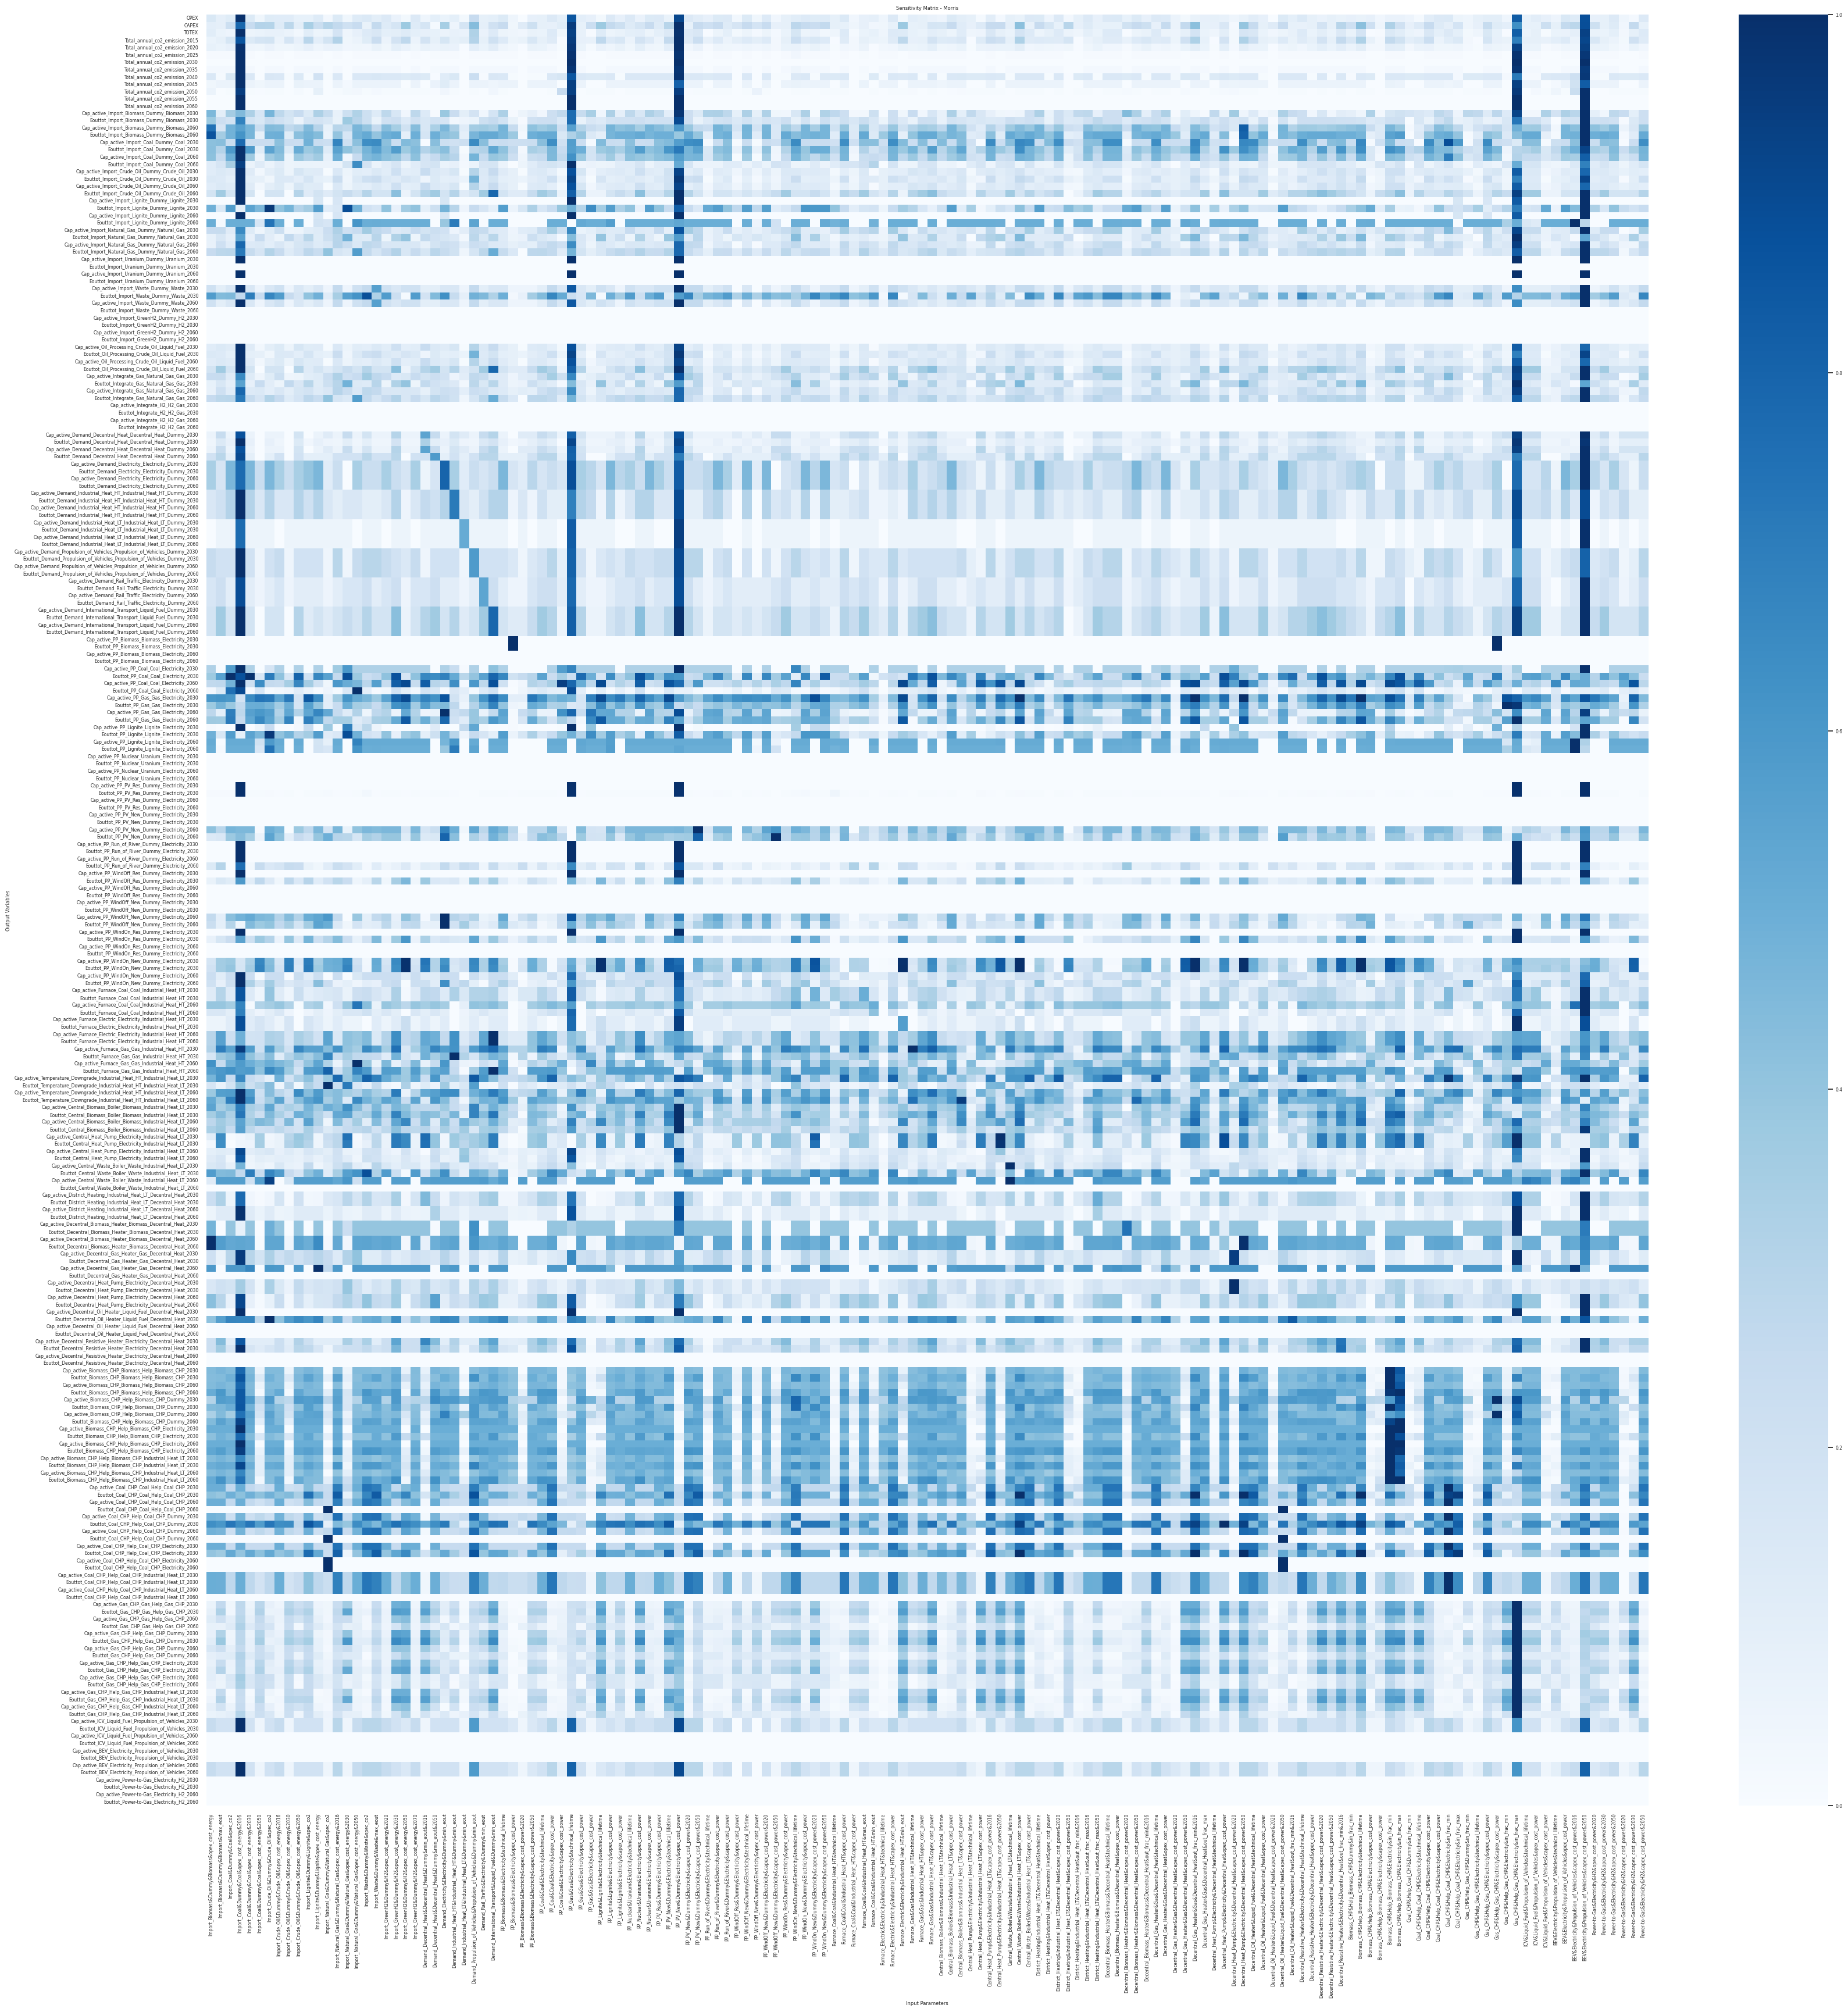

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
sns.set(font_scale=0.5)
plt.figure(figsize=(40, 40))
sns.heatmap(df_morris, annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Morris')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

In [130]:
df_S1 = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/S1.pkl', "rb")) as openfile:
    while True:
        try:
            df_S1.append(pickle.load(openfile))
        except EOFError:
            break
df_S1 = df_S1[0]
df_S2 = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/S2.pkl', "rb")) as openfile:
    while True:
        try:
            df_S2.append(pickle.load(openfile))
        except EOFError:
            break
df_S2 = df_S2[0]
df_ST = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/ST.pkl', "rb")) as openfile:
    while True:
        try:
            df_ST.append(pickle.load(openfile))
        except EOFError:
            break
df_ST = df_ST[0]

In [138]:
rows_to_drop = []
for i in range(df_ST.shape[0]):
    if np.max(df_ST.iloc[i]) < 0.5 and np.max(df_S1.iloc[i]) < 0.5:
        rows_to_drop.append(df_ST.iloc[i].name)

df_ST = df_ST.dropna().drop(rows_to_drop)
df_S1 = df_S1.dropna().drop(rows_to_drop)

In [140]:
diff_total = []
for i in range(df_ST.shape[0]):
    if np.sum(df_ST.iloc[i]) > 1.2*np.sum(df_S1.iloc[i]):
        diff_total.append(df_ST.iloc[i].name)

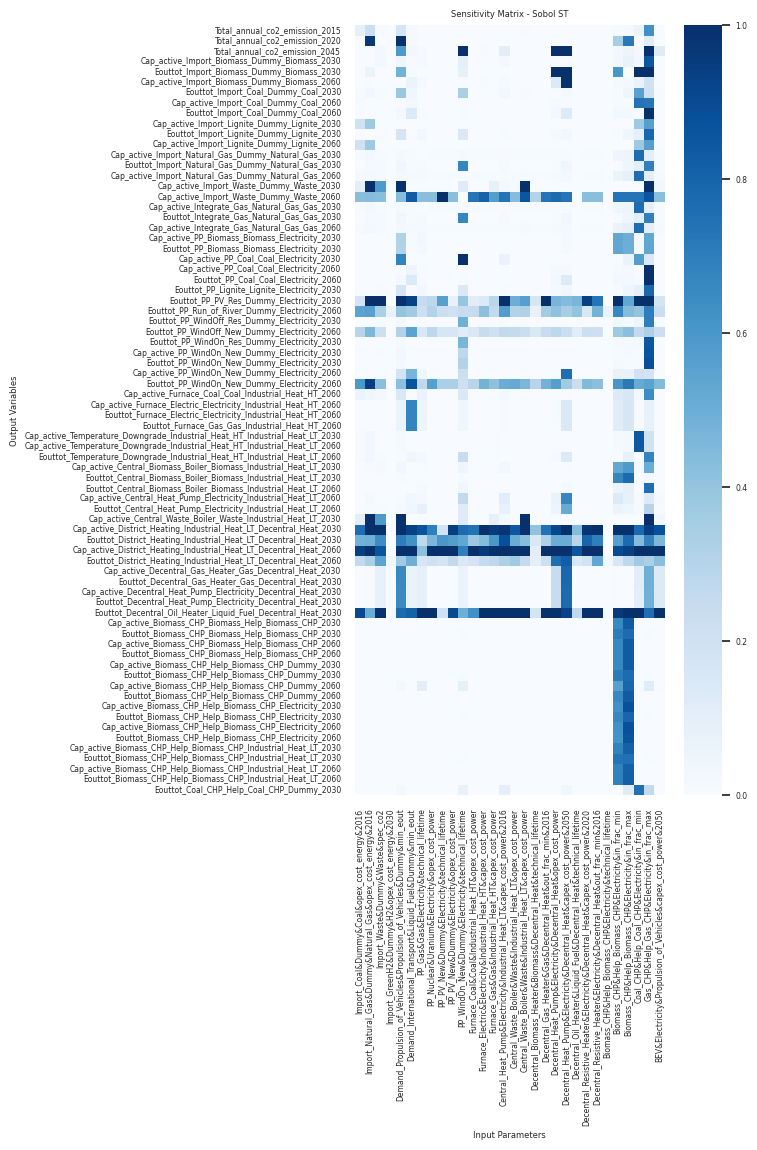

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
sns.set(font_scale=0.5)
plt.figure(figsize=(5, 10))
sns.heatmap(df_ST.loc[diff_total], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol ST')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

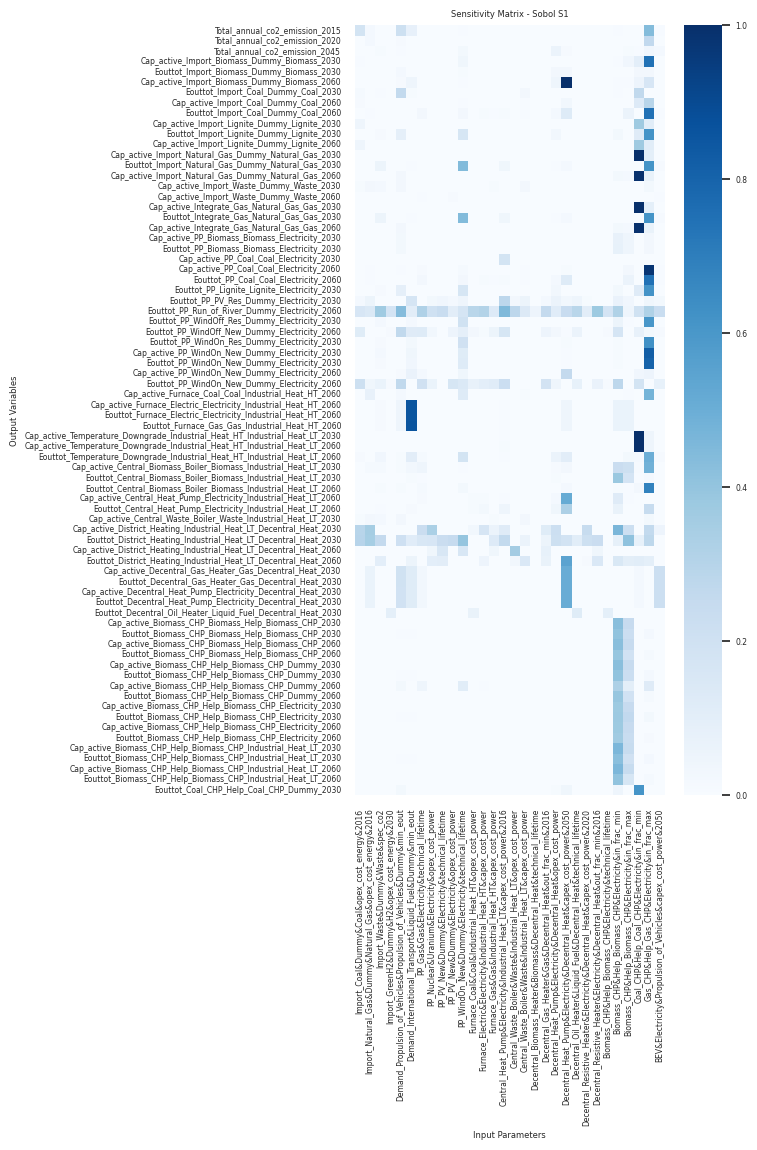

In [148]:
# Plot heatmap
sns.set(font_scale=0.5)
plt.figure(figsize=(5, 10))
sns.heatmap(df_S1.loc[diff_total], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol S1')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

In [53]:
df_y_sobol = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/sobol_Y.pkl', "rb")) as openfile:
    while True:
        try:
            df_y_sobol.append(pickle.load(openfile))
        except EOFError:
            break
df_y_sobol = df_y_sobol[0]

# Calculate the number of feasible runs based on the input dict fields
array_y_sobol = np.empty((len(df_y_sobol['runs']),len(df_y_sobol['runs'][1])))

# Include only the feasible ones in the output lists
idx = 0
for key in df_y_sobol['runs']:
    array_y_sobol[idx] = df_y_sobol['runs'][key]
    idx += 1

problem_sobol = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/sobol_problem_def.pkl', "rb")) as openfile:
    while True:
        try:
            problem_sobol.append(pickle.load(openfile))
        except EOFError:
            break
problem_sobol = problem_sobol[0]

In [113]:
from SALib.analyze.sobol import analyze as sobol_analyze

var_names = df_y_sobol['output_var_names']
param_names = problem_sobol['names']

df_s1 = pd.DataFrame(columns=param_names)
df_s2 = pd.DataFrame(columns=param_names)
df_st = pd.DataFrame(columns=param_names)

# Run the Sobol analysis for each of the output vars
for i in range(array_y_sobol.shape[1]):
    Si = sobol_analyze(problem=problem_sobol,Y=array_y_sobol[:,i])
    # Store each of the indices to a dataframe
    # S1: individual contribution of the param
    # S2: interaction contribution of the param (needs calc_second_order in the sampling)
    # ST: total contribution of the param
    df_s1.loc[var_names[i]] = list(Si['S1'])
    df_s2.loc[var_names[i]] = list(Si['S2'])
    df_st.loc[var_names[i]] = list(Si['ST'])

/home/gutriv/miniconda3/envs/cesm/lib/python3.10/site-packages/SALib/analyze/sobol.py:204: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/home/gutriv/miniconda3/envs/cesm/lib/python3.10/site-packages/SALib/analyze/sobol.py:217: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/home/gutriv/miniconda3/envs/cesm/lib/python3.10/site-packages/SALib/analyze/sobol.py:227: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/home/gutriv/miniconda3/envs/cesm/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gutriv/miniconda3/envs/cesm/lib/python3.10/site-packages/numpy/core/_m

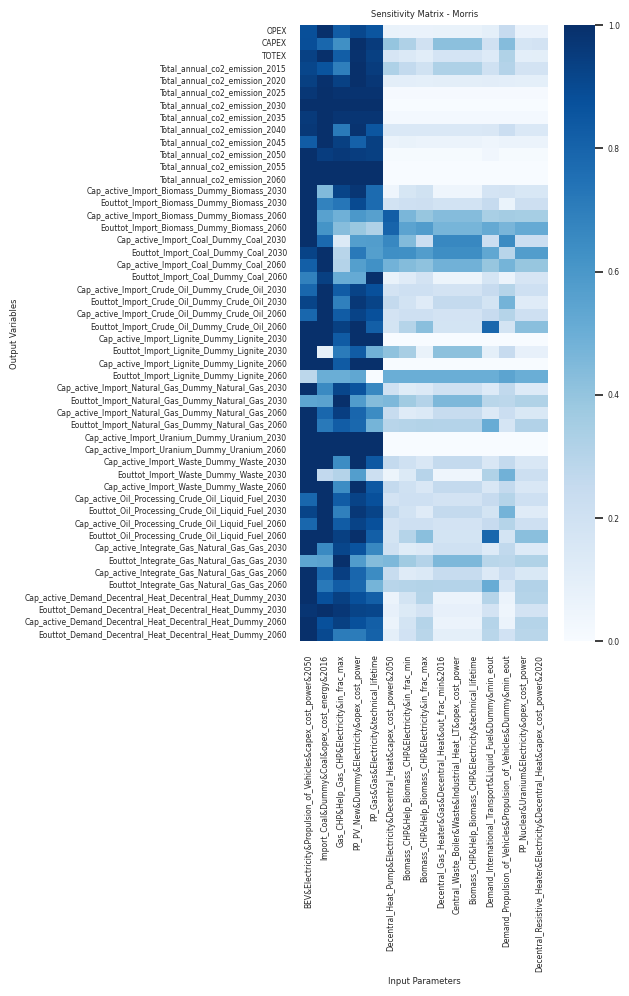

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rows_to_drop = []

for i in range(len(df_morris)):
    if np.max(df_morris.iloc[i]) < 0.5:
        rows_to_drop.append(df_morris.iloc[i].name)

df_morris = df_morris.drop(rows_to_drop)

df_sum = df_morris.sum(axis=0)
top_10 = list(df_sum.sort_values(ascending=False).head(15).index)

m_piece = int(len(df_morris)/4)

# Plot heatmap
sns.set(font_scale=0.5)
plt.figure(figsize=(4, 8))
sns.heatmap(df_morris[top_10].iloc[0:m_piece], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Morris')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

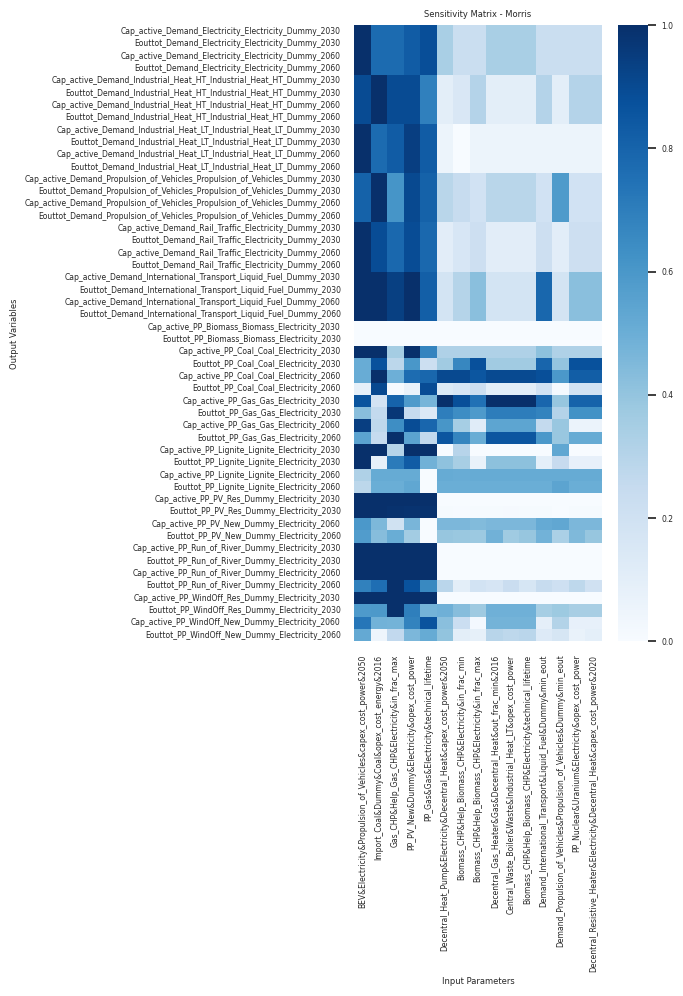

In [6]:
plt.figure(figsize=(4, 8))
sns.heatmap(df_morris[top_10].iloc[m_piece:2*m_piece], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Morris')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

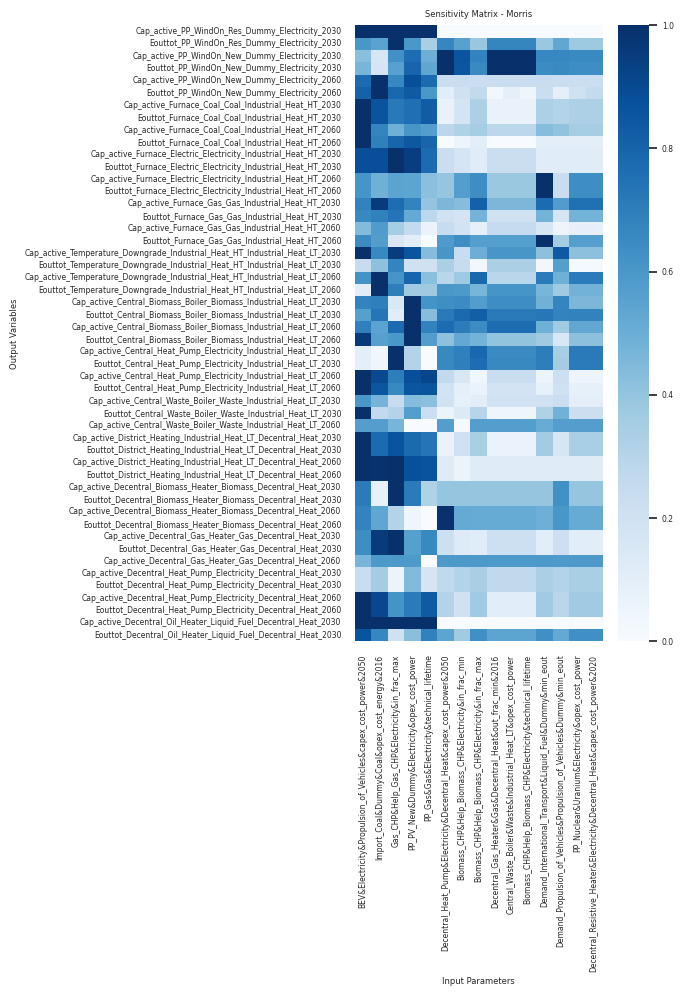

In [7]:
plt.figure(figsize=(4, 8))
sns.heatmap(df_morris[top_10].iloc[2*m_piece:3*m_piece], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Morris')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

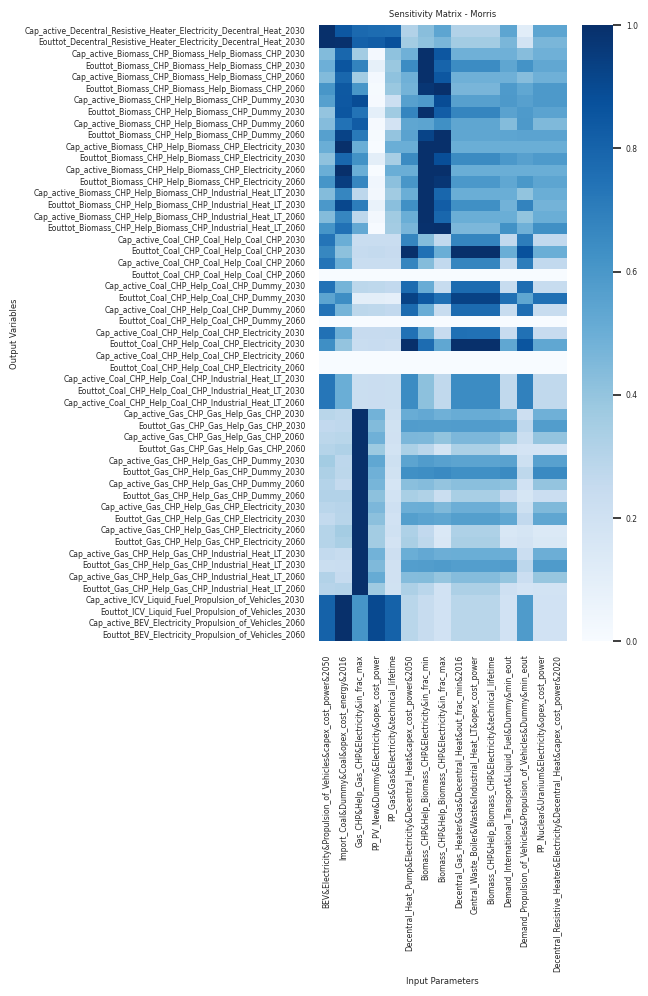

In [8]:
plt.figure(figsize=(4, 8))
sns.heatmap(df_morris[top_10].iloc[3*m_piece:len(df_morris)], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Morris')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

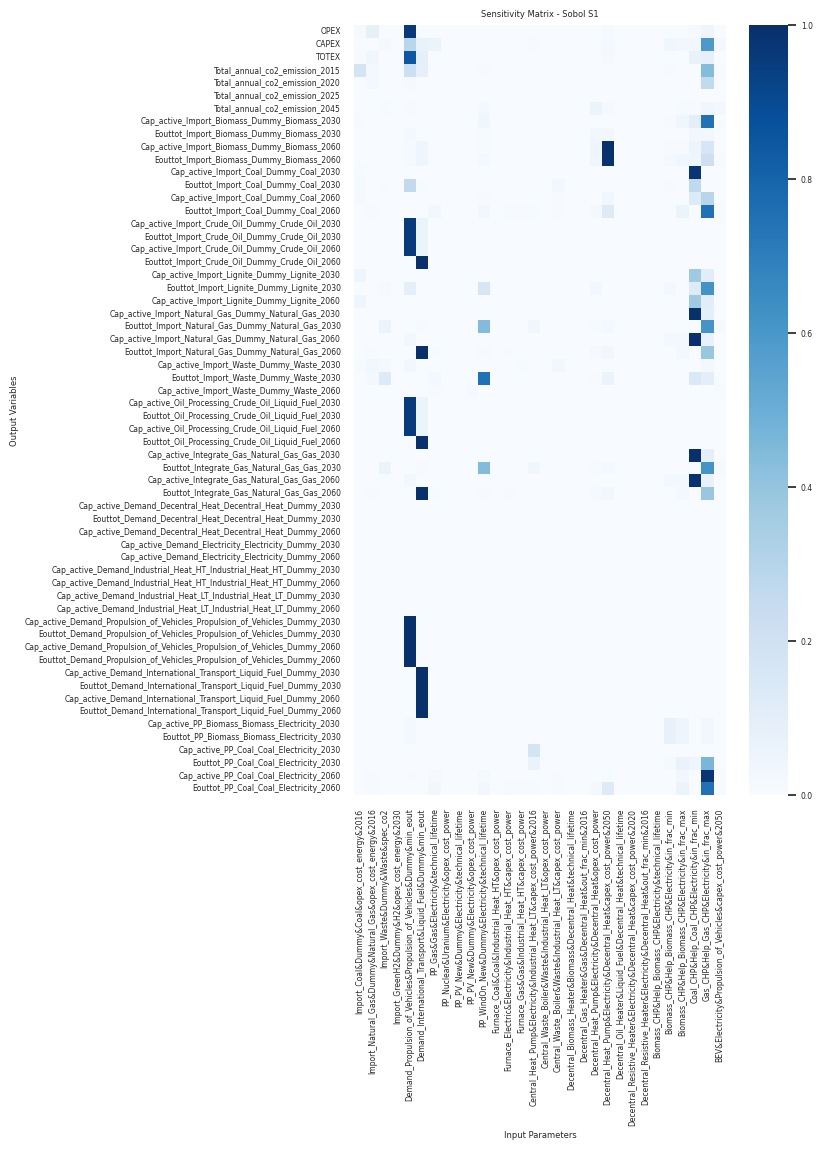

In [120]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.set(font_scale=0.5)
sns.heatmap(df_S1.dropna()[0:60], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol S1')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

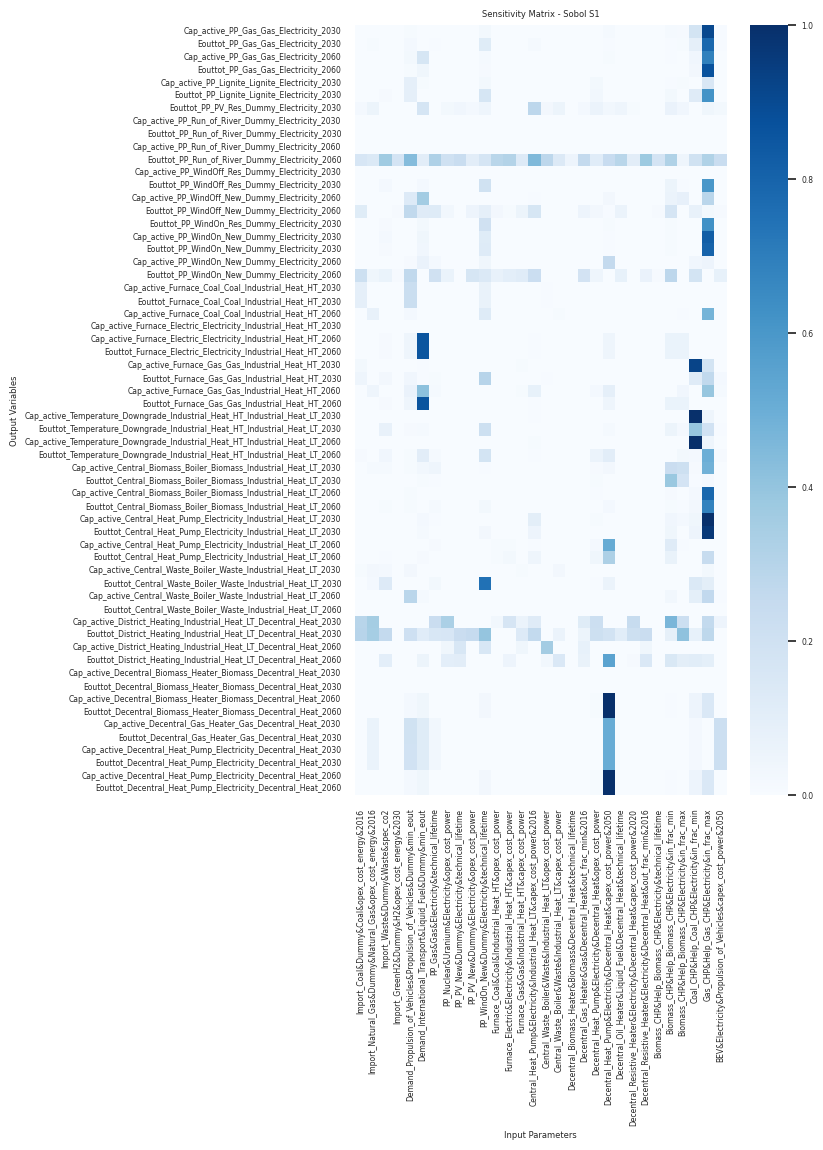

In [121]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.set(font_scale=0.5)
sns.heatmap(df_S1.dropna()[60:120], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol S1')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

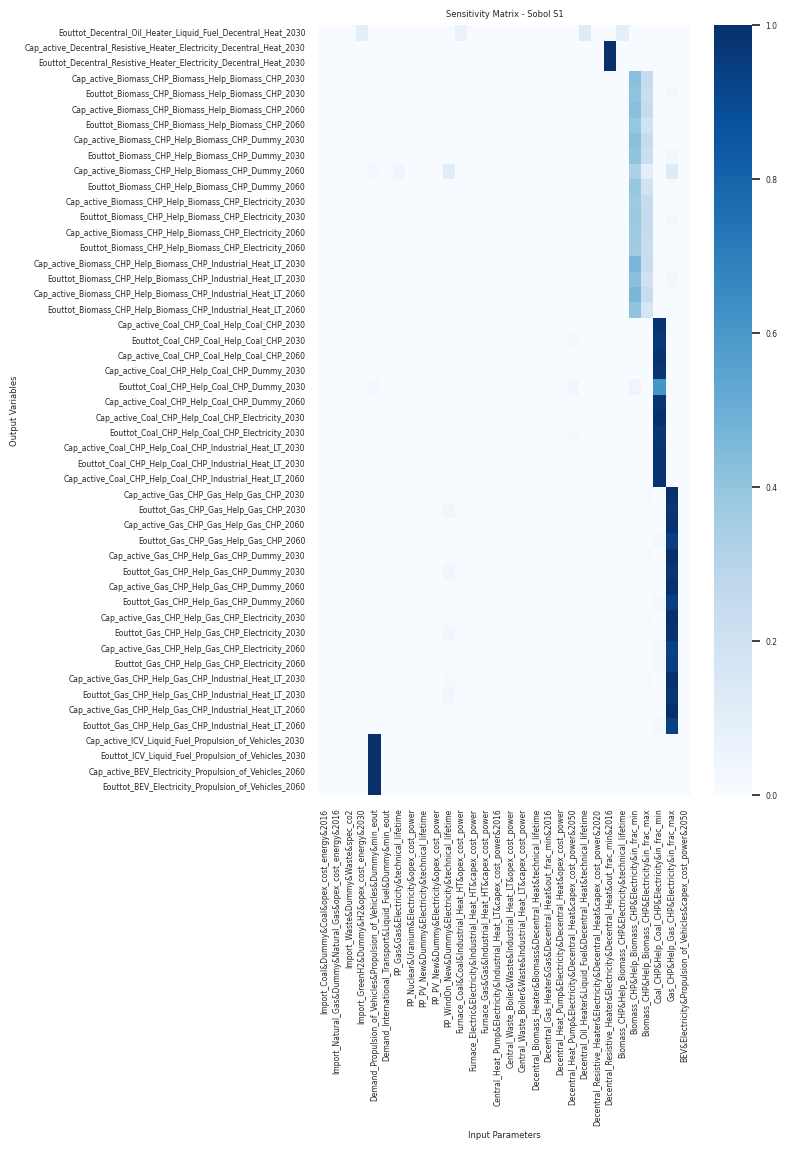

In [122]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.set(font_scale=0.5)
sns.heatmap(df_S1.dropna()[120:171], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol S1')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

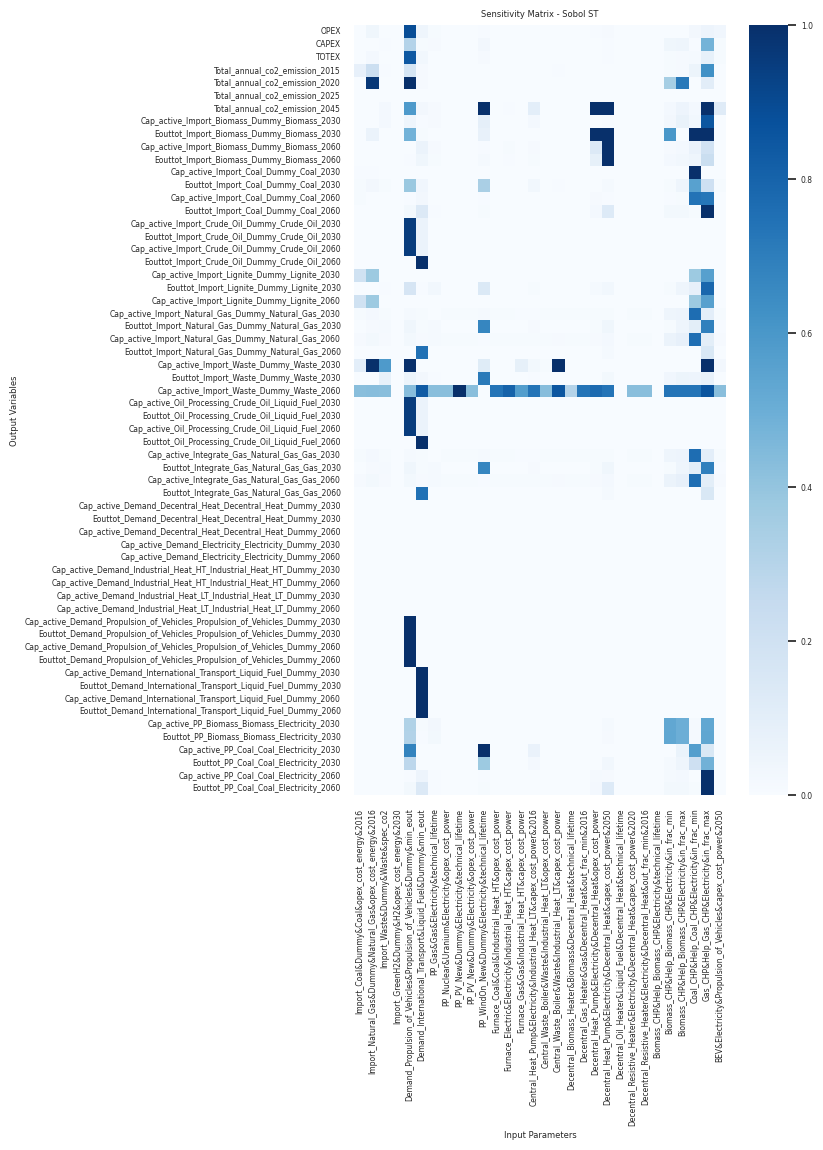

In [123]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.set(font_scale=0.5)
sns.heatmap(df_ST.dropna()[0:60], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol ST')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

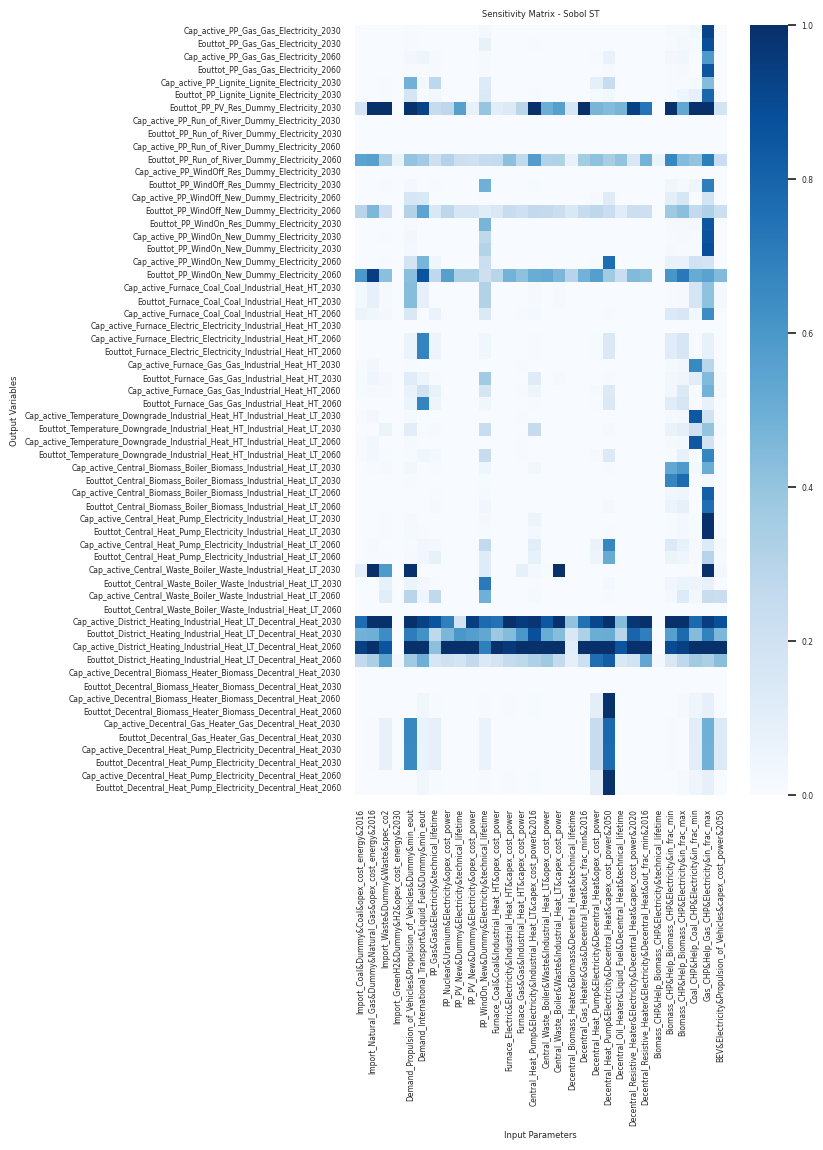

In [124]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.set(font_scale=0.5)
sns.heatmap(df_ST.dropna()[60:120], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol ST')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

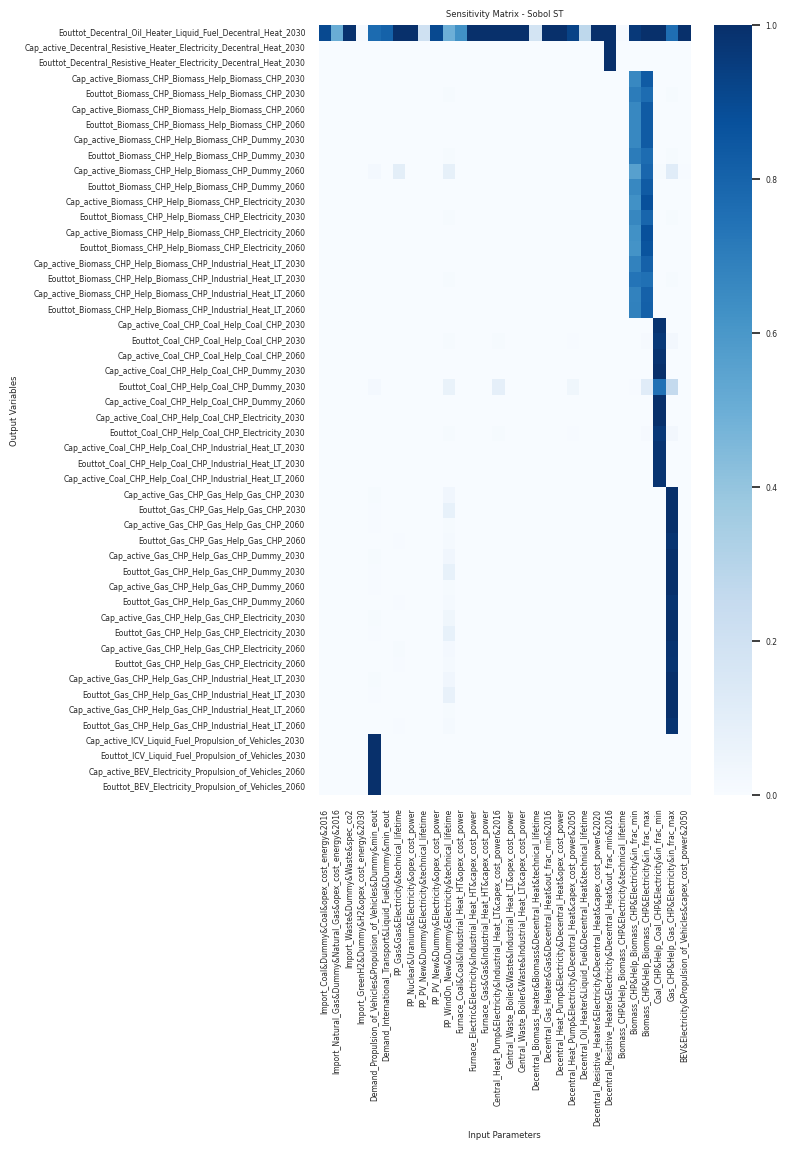

In [125]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.set(font_scale=0.5)
sns.heatmap(df_ST.dropna()[120:171], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol ST')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

In [125]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:

p_param_names = [
    'Import Coal - Operational cost per energy output - 2016',
    'Import Natural Gas - Operational cost per energy output - 2016',
    'Import Waste - Specific CO2 emission/energy output',
    'Import Green H2 - Operational cost per energy output - 2030',
    'Demand for Vehicle Propulsion - Minimum energy output',
    'Demand for International Transport - Minimum energy output',
    'Gas PP - Technical Lifetime',
    'Nuclear PP - Operational cost per active power capacity',
    'New Photovoltaic PP - Technical Lifetime',
    'New Photovoltaic PP - Operational cost per active power capacity',
    'New Wind Onshore PP - Technical Lifetime',
    'Coal furnace for industrial heat - Operational cost per active power capacity',
    'Electric furnace for industrial heat - Capital cost per new power capacity',
    'Gas furnace for industrial heat - Capital cost per new power capacity',
    'Central Heat Pump for industrial heat - Capital cost per new power capacity - 2016',
    'Central Waste Boiler for industrial heat - Operational cost per active power capacity',
    'Central Waste Boiler for industrial heat - Capital cost per new power capacity',
    'Decentral Biomass Heater - Technical lifetime',
    'Decentral Gas Heater - Minimum fraction of output commodity generated - 2016',
    'Decentral Heat Pump - Operational cost per active power capacity',
    'Decentral Heat Pump - Capital cost per new power capacity - 2050',
    'Decentral Oil Heater - Technical lifetime',
    'Decentral Resistive Heater - Capital cost per new power capacity - 2020',
    'Decentral Resistive Heater - Minimum fraction of output commodity generated - 2016',
    'Biomass CHP - Technical lifetime',
    'Biomass CHP - Minimum fraction of input commodity consumed',
    'Biomass CHP - Maximum fraction of input commodity consumed',
    'Coal CHP - Minimum fraction of input commodity consumed',
    'Gas CHP - Maximum fraction of input commodity consumed',
    'Electricity for BEV propulsion - Capital cost per new power capacity - 2050',
]

p_var_names = [
    'Total annual CO2 emission - 2015',
    'Total annual CO2 emission - 2020',
    'Total annual CO2 emission - 2045',
    'Import Biomass - Active capacity - 2030',
    'Import Biomass - Total energy output - 2030',
    'Import Coal - Total energy output - 2030',
    'Import Coal - Active capacity - 2060',
    'Import Coal - Total energy output - 2060',
    'Import Lignite - Active capacity - 2030',
    'Import Lignite - Total energy output - 2030',
    'Import Lignite - Active capacity - 2060',
    'Import Natural Gas - Active capacity - 2030',
    'Import Natural Gas - Total energy output - 2030',
    'Import Natural Gas - Active capacity - 2060',
    'Import Waste - Active capacity - 2030',
    'Import Waste - Active capacity - 2060',
    'Integrate Gas - Active capacity - 2030',
    'Integrate Gas - Total energy output - 2030',
    'Integrate Gas - Active capacity - 2060',
    'Biomass PP - Active capacity - 2030',
    'Biomass PP - Total energy output - 2030',
    'Coal PP - Active capacity - 2030',
    'Coal PP - Active capacity - 2060',
    'Coal PP - Total energy output - 2060',
    'Lignite PP - Total energy output - 2030',
    'Photovoltaic PP - Total energy output - 2030',
    'Run of River PP - Total energy output - 2060',
    'Residual Wind Offshore PP - Total energy output - 2030',
    'New Wind Offshore PP - Total energy output - 2060',
    'Residual Wind Onshore PP - Total energy output - 2030',
    'New Wind Onshore PP - Active capacity - 2030',
    'New Wind Onshore PP - Total energy output - 2030',
    'New Wind Onshore PP - Active capacity - 2060',
    'New Wind Onshore PP - Total energy output - 2060',
    'Coal Furnace - Active capacity - 2060',
    'Electric Furnace - Active capacity - 2060',
    'Electric Furnace - Total energy output - 2060',
    'Gas Furnace - Total energy output - 2060',
    'Temperature Downgrade for Industrial Heat - Active capacity - 2030',
    'Temperature Downgrade for Industrial Heat - Active capacity - 2060',
    'Central Biomass Boiler - Active capacity - 2030',
    'Central Biomass Boiler - Total energy output - 2030',
    'Central Biomass Boiler - Total energy output - 2060',
    'Central Heat Pump - Active capacity - 2060',
    'Central Heat Pump - Total energy output - 2060',
    'Central Waste Boiler - Active capacity - 2030',
    'District Heating - Active capacity - 2030',
    'District Heating - Total energy output - 2030',
    'District Heating - Active capacity - 2060',
    'District Heating - Total energy output - 2060',
    'Decentral Gas Heater - Active capacity - 2030',
    'Decentral Gas Heater - Total energy output - 2030',
    'Decentral Heat Pump - Active capacity - 2030',
    'Decentral Heat Pump - Total energy output - 2030',
    'Decentral Oil Heater - Total energy output - 2030',
    'Biomass CHP - Active capacity - 2030',
    'Biomass CHP - Total energy output - 2030',
    'Biomass CHP - Active capacity - 2060',
    'Biomass CHP - Total energy output - 2060',
    'Biomass CHP Help (Dummy) - Active capacity - 2030',
    'Biomass CHP Help (Dummy) - Total energy output - 2030',
    'Biomass CHP Help (Dummy) - Active capacity - 2060',
    'Biomass CHP Help (Dummy) - Total energy output - 2060',
    'Biomass CHP Help (Electricity) - Active capacity - 2030',
    'Biomass CHP Help (Electricity) - Total energy output - 2030',
    'Biomass CHP Help (Electricity) - Active capacity - 2060',
    'Biomass CHP Help (Electricity) - Total energy output - 2060',
    'Biomass CHP Help (Industrial Heat) - Active capacity - 2030',
    'Biomass CHP Help (Industrial Heat) - Total energy output - 2030',
    'Biomass CHP Help (Industrial Heat) - Active capacity - 2060',
    'Biomass CHP Help (Industrial Heat) - Total energy output - 2060',
    'Coal CHP Help (Dummy) - Total energy output - 2030'
]

In [127]:
df_S1 = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/S1.pkl', "rb")) as openfile:
    while True:
        try:
            df_S1.append(pickle.load(openfile))
        except EOFError:
            break
df_S1 = df_S1[0]

df_S2 = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/S2.pkl', "rb")) as openfile:
    while True:
        try:
            df_S2.append(pickle.load(openfile))
        except EOFError:
            break
df_S2 = df_S2[0]

df_ST = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/ST.pkl', "rb")) as openfile:
    while True:
        try:
            df_ST.append(pickle.load(openfile))
        except EOFError:
            break
df_ST = df_ST[0]

In [128]:
df_S1 = df_S1.dropna()
df_ST = df_ST.dropna()
df_S2 = df_S2.dropna()

var_names = list(df_ST.index)
param_names = list(df_ST.columns)

rows_to_drop = []
cols_to_drop = []

for i in range(df_S1.shape[0]):
    if (np.max(df_S1.iloc[i]) < 0.5 and np.max(df_ST.iloc[i]) < 0.5) or (np.sum(df_S1.iloc[i]) > 0.8*np.sum(df_ST.iloc[i])):
        rows_to_drop.append(var_names[i])

for i in range(df_S1.shape[1]):
    if (np.max(df_S1.iloc[i]) < 0.5 and np.max(df_ST.iloc[i]) < 0.5):
        cols_to_drop.append(param_names[i])

df_S1 = df_S1.drop(rows_to_drop)
#df_S1 = df_S1.drop(cols_to_drop, axis=1)
df_ST = df_ST.drop(rows_to_drop)
#df_ST = df_ST.drop(cols_to_drop, axis=1)
df_S2 = df_S2.drop(rows_to_drop)

var_names = list(df_ST.index)
param_names = list(df_ST.columns)

In [103]:
row = 1
col = 4
full_df_S2 = np.array(df_S2.iloc[row,col])

for i in range(col):
    full_df_S2[i] = df_S2.iloc[row,i][col]

full_df_S2

array([-0.00050475, -0.01645418, -0.00873893,  0.        ,         nan,
        0.05182454,  0.04278593,  0.04307585,  0.04307585,  0.04307585,
        0.04259186,  0.04334079,  0.04307585,  0.04678482,  0.04307585,
        0.04307585,  0.04307585,  0.04307585,  0.04307585,  0.04273904,
        0.04259186,  0.04307585,  0.04307585,  0.04197096,  0.04307585,
        0.04294181,  0.04413907,  0.04307585,  0.20353872,  0.0427201 ])

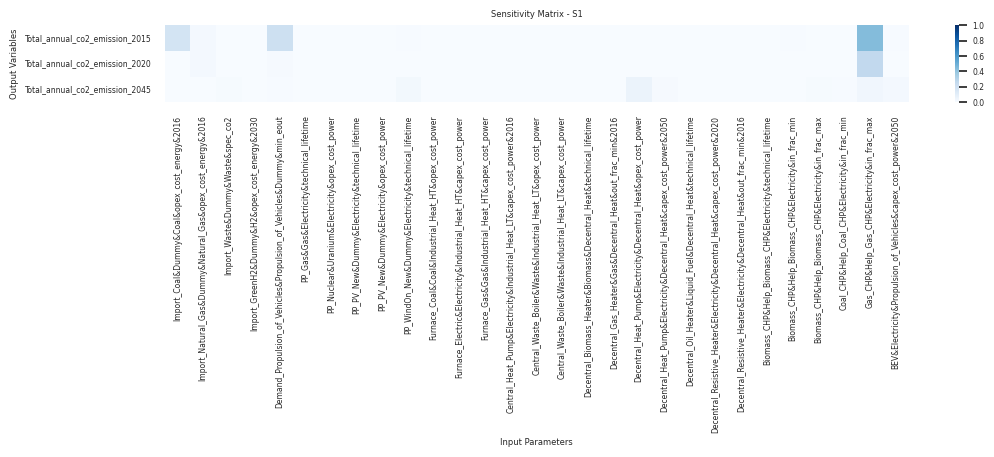

In [28]:
sns.set(font_scale=0.5)
plt.figure(figsize=(12, 1))
sns.heatmap(df_S1[0:3], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - S1')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

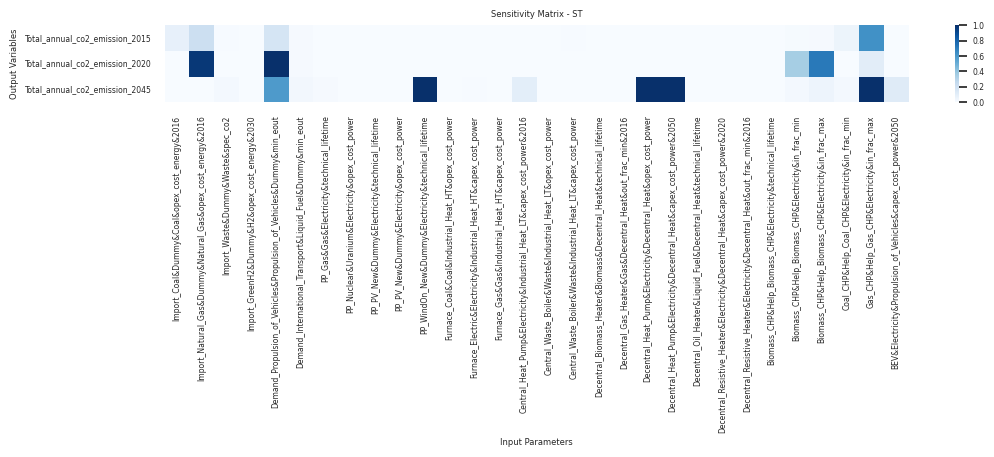

In [224]:
sns.set(font_scale=0.5)
plt.figure(figsize=(12, 1))
sns.heatmap(df_ST.iloc[0:3], annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - ST')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

In [329]:
for idx in range(len(p_var_names)):
    order_2_df = pd.DataFrame(columns=p_param_names,index=p_param_names)

    for i in range(len(p_param_names)):
        order_2 = df_S2.iloc[idx,i]
        for j in range(i):
            order_2[j] = df_S2.iloc[idx,j][i]
        order_2 = np.array(order_2).reshape(len(order_2),1)
        order_2_df.iloc[:,i] = order_2
    order_2_df = order_2_df.apply(pd.to_numeric)

    fig = plt.figure(figsize=(6, 6))
    sns.set(font_scale=0.5)
    hm = sns.heatmap(order_2_df, annot=False, cmap=sns.color_palette("coolwarm_r", as_cmap=True), fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Sensitivity Matrix - S2 - {p_var_names[idx]}')
    plt.xlabel('Input Parameters')
    plt.ylabel('Output Variables')
    #plt.show()
    hm_fig = hm.get_figure()
    hm_fig.savefig(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/Plots/Parameters_S2/{idx}_{p_var_names[idx]}_ST_S1.png', dpi=400, bbox_inches="tight")
    plt.close(fig)

In [319]:
for idx in range(len(p_var_names)):
    th = 0.01
    output_var = p_var_names[idx]

    S1 = df_S1.iloc[idx]
    ST = df_ST.iloc[idx]
    params = np.array(p_param_names)

    # Sort arrays based on the first array
    sort_idx = np.argsort(ST)
    ST = ST.iloc[sort_idx]
    S1 = S1.iloc[sort_idx]
    params = params[sort_idx]

    # Cut values under the threshold
    keep = ST >= th
    ST = ST[keep]
    S1 = S1[keep]
    params = params[keep]

    # Plotting
    bar_width = 0.8
    index = np.arange(len(params))

    fig = plt.figure(figsize=(10, len(ST)*0.5))

    for i in range(len(params)):
        if S1.iloc[i] > ST.iloc[i]:
            if i == len(params)-1:
                plt.legend(['ST','S1'])
            plt.barh(i, ST.iloc[i], bar_width, color='r')
            plt.barh(i, S1.iloc[i] - ST.iloc[i], bar_width, color='b', left=ST.iloc[i])
        else:
            if i == len(params)-1:
                plt.legend(['S1','ST'])
            plt.barh(i, S1.iloc[i], bar_width, color='b')
            plt.barh(i, ST.iloc[i] - np.clip(S1.iloc[i], 0, 10), bar_width, color='r', left=np.clip(S1.iloc[i], 0, 10))

    plt.yticks(index, params)
    plt.xlabel('Sensitivity Index')
    plt.title(f'Sensitivity Analysis for {output_var}')
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/Plots/Parameters_ST_S1/{idx}_{output_var}_ST_S1.png')
    plt.close(fig)
